# Preparation work

In [ ]:
!pip install roboflow --quiet
!pip install ultralytics opencv-python matplotlib --quiet

# restart
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.6 MB/s eta 0:00:00


{'status': 'ok', 'restart': True}

## GET KEY
what is the format for KEY.txt<br>
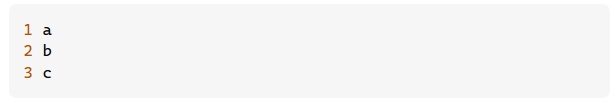

In [ ]:
# create connection
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# read the key value for Dataset and GitHub
%cd /content/drive/MyDrive

# hold the key with dict
keys = {}

with open("KEY.txt") as f :
  # open success
  for line in f :
    if not line or line.isspace() :
      # when empty
      break;

    (key, val) = line.split()
    keys[key] = val # store the value
    print(f"{key} store success!")

# switch back
%cd /content/

/content/drive/MyDrive
RobotFlow store success!
GitHub store success!
/content


In [ ]:
from roboflow import Roboflow # import get dataset

rf = Roboflow(api_key=keys["RobotFlow"])
project = rf.workspace("crabbbb").project("human-in-bus-stop")
version = project.version(5)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Human-in-Bus-Stop-5 in yolov11:: 100%|██████████| 700/700 [00:00<00:00, 3789.20it/s]


# Try Solve Overwrite Model Classes Problem
This problem happen when using custom dataset to train the model, it will cause the original class that able to be detected by yolo be overwrite <br><br>
To understand more can use the code below to try the model after and before training :


```
# to show the all the class that able to be detect by YOLO
model = YOLO(YOUR_MODEL_NAME)
model.names
```



In [ ]:
# prepare model
from ultralytics import YOLO

model = YOLO("yolo11s.pt")

100%|██████████| 18.4M/18.4M [00:00<00:00, 304MB/s]


## Generate new names and nc try to modify data.yaml to solve problem

In [ ]:
# required class is person, bus and leg (custom) detect
clsRequiredList = ['person', 'bus']

# get class
cls = model.names

cls

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 49.0M/49.0M [00:00<00:00, 337MB/s]


{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou

In [ ]:
# generate new names
base = "names: ["

stopAt = 0
i = 0

while i < len(clsRequiredList) :
  # loop cls to find what we need
  for j in range(stopAt, len(cls)) :
    print(j, i)
    # since based on the dataset leg annotated class id is 1, and classes 1 for original model is unused in this case, to prevent doing more step, at here will use back 1
    if j == 1 :
      base = f"{base} 'leg',"
      i -= 1
      stopAt += 1 # prevent id 1 = None
      break

    if clsRequiredList[i] == cls[j] :
      # match
      base = f"{base} '{cls[j]}'"
      if i != len(clsRequiredList)-1 :
        # not end
        base = f"{base},"
      else :
        base = f"{base}]"
      stopAt += 1
      break
    else :
      # no match
      base = f"{base} 'None',"
      stopAt += 1
  i += 1

0 0
1 1
2 1
3 1
4 1
5 1


In [ ]:
base # names

"names: [ 'person', 'leg', 'None', 'None', 'None', 'bus']"

In [ ]:
# new nc
# number of retained class + new class
nc = len(clsRequiredList) + 1

nc

3

In [ ]:
yamlPath = "/content/Human-in-Bus-Stop-5/data.yaml"

rowNoOfNC = 5
rowNoOfNames = 6

# put single '' inside is because of execute sed command first value pass in must be string
# so when {test} will print '5s/.*/nc: 3/' and it is a string value
ncSentence = f"'{rowNoOfNC}s/.*/nc: {nc}/'"
namesSentence = f"'{rowNoOfNames}s/.*/{base}/'"

# edit the data.yaml file to ensure nc and names is correct
!sed -i {ncSentence} {yamlPath}
!sed -i {namesSentence} {yamlPath}

In [ ]:
!cat {yamlPath}

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 3
names: [ 'person', 'leg', 'None', 'None', 'None', 'bus']

roboflow:
  workspace: crabbbb
  project: human-in-bus-stop
  version: 1
  license: CC BY 4.0
  url: https://universe.roboflow.com/crabbbb/human-in-bus-stop/dataset/1

## Train Model

NOTE : Remove the row with id 0 which under Human-in-Bus-Stop/test/label/frame_0.jpg....txt

In [ ]:
!yolo task=detect mode=train model=yolo11s.pt data=/content/Human-in-Bus-Stop-5/data.yaml epochs=25 imgsz=640

Ultralytics 8.3.36 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/Human-in-Bus-Stop-5/data.yaml, epochs=25, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tru

In [ ]:
# change nc to 6, since based on error message have show that None also need to be include
ncSentence = f"'{rowNoOfNC}s/.*/nc: 6/'"

!sed -i {ncSentence} {yamlPath}

In [ ]:
# remove runs folder
!rm -rdf /content/runs

In [ ]:
!yolo task=detect mode=train model=yolo11s.pt data=/content/Human-in-Bus-Stop-5/data.yaml epochs=25 imgsz=640

Ultralytics 8.3.36 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/Human-in-Bus-Stop-5/data.yaml, epochs=25, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True


image 1/1 /content/humanSmall.jpg: 448x640 (no detections), 12.8ms
Speed: 1.2ms preprocess, 12.8ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


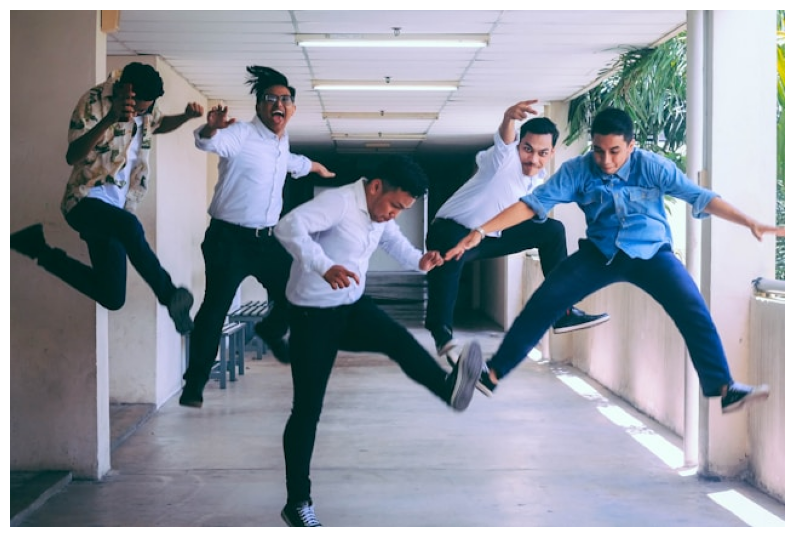

In [ ]:
# access to the model, test is that still able to detect human
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2

bestModelPath = "/content/runs/detect/train/weights/best.pt"

# upload an image that contain person inside
imagePath = "/content/humanSmall.jpg"

model = YOLO(bestModelPath)

# id 0 is person
result = model(imagePath, classes=[0])

# display the result
annotatedImage = result[0].plot()

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(annotatedImage, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [ ]:
model.names

{0: 'person', 1: 'leg', 2: 'None', 3: 'None', 4: 'None', 5: 'bus'}

# Conclusion

from the result above can saw person still inside the class can be identify by model but the ability to detect person already lost<br>
means this method can helping on solving the overwrite problem